In [50]:
import os
import numpy as np
import xarray as xr
import pop_tools
import gsw
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

# MAP

In [20]:
# Define file path and name
path = '/Data/skd/scratch/innag3580/comp/averages/'
temp_file = 'TEMP_mean_185001-185912.nc'
salt_file = 'SALT_mean_185001-185912.nc'

# Load data
ds_temp = xr.open_dataset(os.path.join(path, temp_file))
ds_salt = xr.open_dataset(os.path.join(path, salt_file))

CT = gsw.conversions.CT_from_pt(ds_salt['SALT'], ds_temp['TEMP'])
sigma2 = gsw.density.sigma2(ds_salt['SALT'], CT)
sigma2 = xr.DataArray(sigma2, name='DENS2', dims=ds_temp['TEMP'].dims, coords=ds_temp['TEMP'].coords)

/home/innag3580/.conda/envs/movie/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sigma2
  result_data = func(*input_data)


In [27]:
ds_dens = ds_temp
ds_dens = ds_dens.drop_vars('TEMP')
ds_dens['DENS2'] = sigma2

nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', linewidth=0.5, edgecolor='black', facecolor='whitesmoke')

# Define regions and masks
grid_name = 'POP_gx1v7'
region_defs = {
        'subzero_Atlantic':[
            {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 70.0], 'TLONG': [260.0, 360.0]}}
        ],
        #'superzero_Atlantic':[
        #    {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 70.0], 'TLONG': [0, 20.0]}}
        #],
        'Mediterranean': [
            {'match': {'REGION_MASK': [7]}}
        ],
        'LabradorSea': [
            {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [10.0, 70.0]}}
        ],
            'NordicSea': [
            {'match': {'REGION_MASK': [9]}, 'bounds': {'TLAT': [10.0, 70.0], 'TLONG': [260.0, 360.0]}}
        ]
    }
mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs)
mask = mask.sum('region')

slice_upper_1000 = slice(5.0000000e+02, 9.8470586e+04)
slice_upper_500  = slice(5.0000000e+02, 5.5000000e+03)
ds_dens = ds_dens.sel(z_t=slice_upper_500).mean(dim=['z_t','time'])

replacement_value = 0
ds_dens['TLAT'] = xr.where(
    np.logical_or(np.isnan(ds_dens['TLAT']), np.logical_or(np.isinf(ds_dens['TLAT']), np.ma.getmask(ds_dens['TLAT']))),
    replacement_value,
    ds_dens['TLAT'])
ds_dens['TLONG'] = xr.where(
    np.logical_or(np.isnan(ds_dens['TLONG']), np.logical_or(np.isinf(ds_dens['TLONG']), np.ma.getmask(ds_dens['TLONG']))),
    replacement_value,
    ds_dens['TLONG'])

In [28]:
# Compute mean and prepare plotting data
plotting_data = ds_dens.DENS2

# Set up color and label sizes
cbar_kwargs = {
    'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
    'label': r'Surface Density $\sigma_2$ [$\frac{kg}{m^3} -1000$]', 'pad': 0.05
}
labelsize = 20

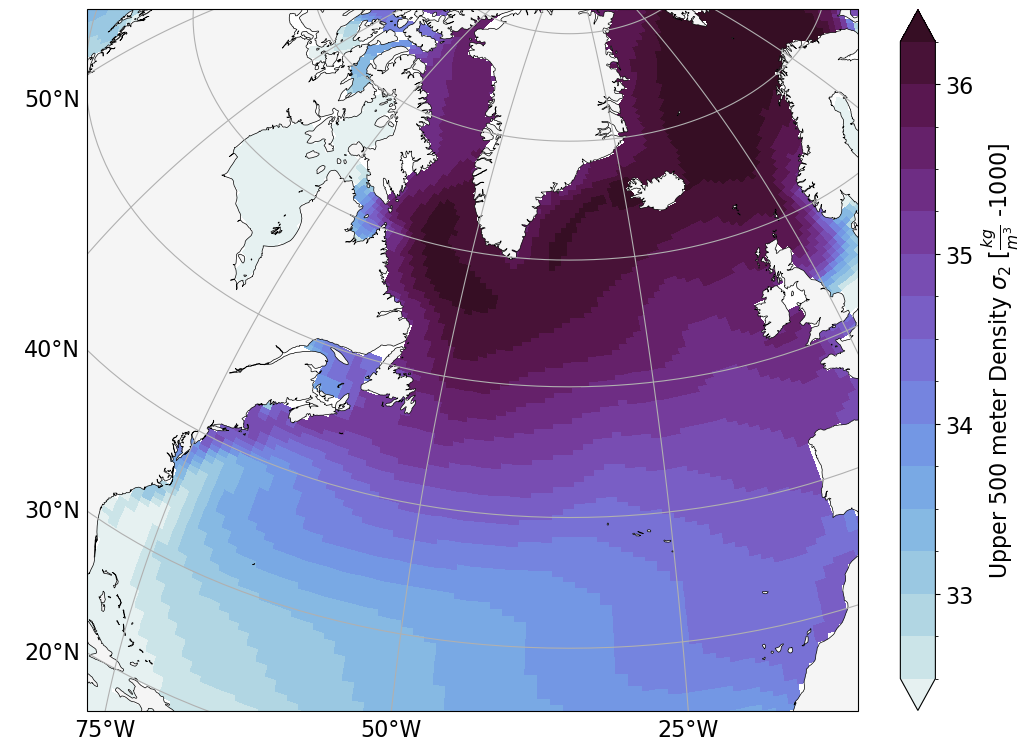

In [77]:
vmin = 32.5
vmax = 36.5
labelsize = 16  # Set your desired fontsize

# Discretize colormap
levels = np.arange(vmin, vmax, 0.25)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=len(levels)-1)

# Specify fewer ticks for the colorbar
colorbar_ticks = np.arange(vmin + 0.5, vmax, 1)  # Adjust the step to reduce the number of ticks

# Plot configuration
plt.figure(figsize=(11, 13))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=40, central_longitude=-35))
ax.set_extent([-80, -10, 25, 80], crs=ccrs.PlateCarree())

# Plotting data as pcolormesh
pc = plotting_data.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    x='TLONG',
    y='TLAT',
    cbar_kwargs={
        'ticks': colorbar_ticks,
        'label': r'Surface Density [$\frac{kg}{m^3}$]',  # Add the desired label here
        'extend': 'both',
        'fraction': 0.046,  # Make the colorbar thinner
        'pad': 0.05,
        'shrink': 0.7  # Shorten the colorbar from top and bottom
    },
    cmap=cmo.dense,
    norm=norm
)

# Adjust colorbar label size
pc.colorbar.ax.tick_params(labelsize=labelsize)
pc.colorbar.set_label(r'Upper 500 meter Density $\sigma_2$ [$\frac{kg}{m^3}$ -1000]', size=labelsize)

# Axis ticks
ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)

# Add gridlines
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': labelsize}
gl.ylabel_style = {'size': labelsize}

# Add coastlines
ax.add_feature(nature_coast)

# Add a white patch outside the plot area to cover one of the ticks
# Adjust the position and size accordingly to cover the desired tick
patch = Rectangle((-0.1, 0.9), 0.09, 0.06, transform=ax.transAxes, color='white', zorder=10, clip_on=False)
ax.add_patch(patch)

#plt.show() 
plt.savefig('Figure_Density_map.png', bbox_inches='tight', dpi=300)

# old plot

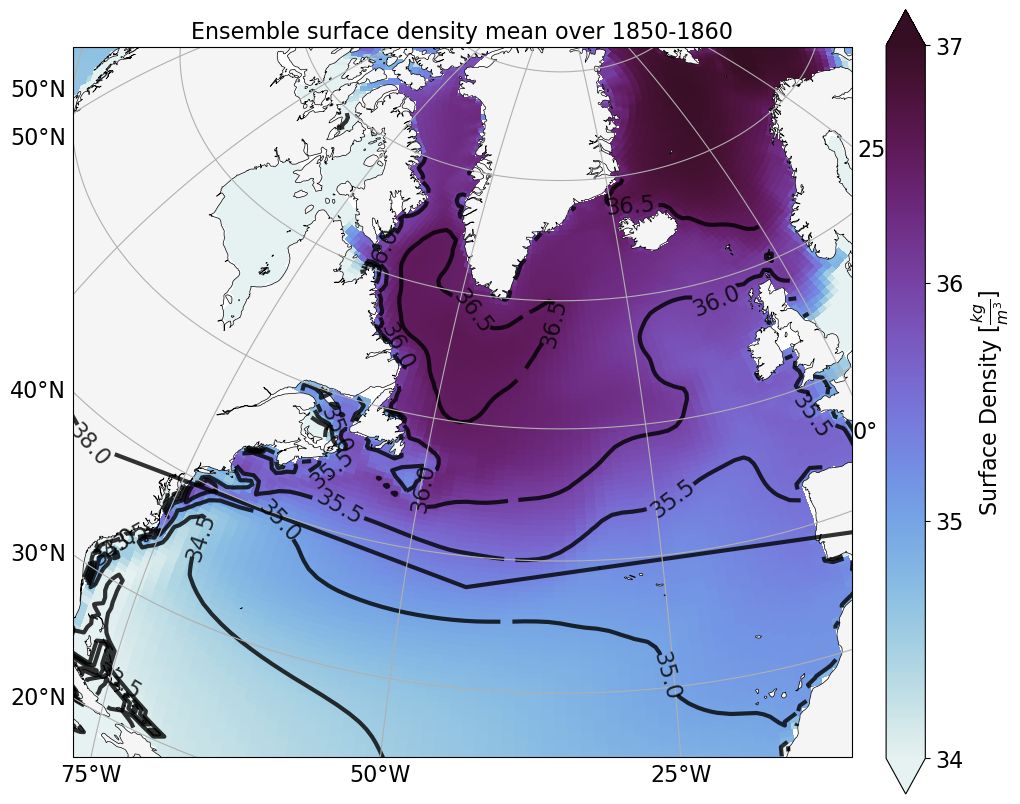

In [7]:
vmin = 34
vmax = 37
labelsize = 16  # Set your desired fontsize

# Plot configuration
plt.figure(figsize=(11, 13))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=40, central_longitude=-35))
ax.set_extent([-80, -10, 25, 80], crs=ccrs.PlateCarree())

# Plotting data as pcolormesh
pc = plotting_data.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    x='TLONG',
    y='TLAT',
    cbar_kwargs={
        'ticks': np.arange(vmin, vmax + 1, 1),
        'label': 'Surface Density [$\frac{kg}{m^3}$]',  # Add the desired label here
        'extend': 'both',
        'fraction': 0.046,  # Make the colorbar thinner
        'pad': 0.04
    },
    cmap=cmo.dense,
    vmin=vmin,
    vmax=vmax
)

# Adjust colorbar label size
pc.colorbar.ax.tick_params(labelsize=labelsize)
pc.colorbar.set_label(r'Surface Density [$\frac{kg}{m^3}$]', size=labelsize)

# Axis ticks
ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)

# Add gridlines
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': labelsize}
gl.ylabel_style = {'size': labelsize}

# Add coastlines
ax.add_feature(nature_coast)
plt.title('Ensemble surface density mean over 1850-1860', fontsize=labelsize)

# Contour settings
contour_levels = np.arange(np.floor(plotting_data.min().item()),
                           np.ceil(plotting_data.max().item()) + 0.5, 0.5)
cs = ax.contour(ds_dens.TLONG, ds_dens.TLAT, 
                plotting_data.where(mask > 0), 
                levels=contour_levels, 
                alpha=0.8,
                linewidths=3, 
                colors='black', 
                transform=ccrs.PlateCarree())
ax.clabel(cs, fmt='%1.1f', inline=True, fontsize=labelsize)

plt.show()
#plt.savefig('Figure_Density_map.png', bbox_inches='tight', dpi=300)      